<a href="https://colab.research.google.com/github/jonkrohn/ML-foundations/blob/master/notebooks/regression-in-pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regression in PyTorch

In this notebook, we use the PyTorch **automatic differentiation** library to fit a straight line to data points. Thus, here we use calculus to solve the same regression problem that we used the Moore-Penrose Pseudoinverse to solve in the [*Linear Algebra II* notebook](https://github.com/jonkrohn/ML-foundations/blob/master/notebooks/2-linear-algebra-ii.ipynb).

In [1]:
import torch
import matplotlib.pyplot as plt

In [2]:
x = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7.])

The $y$ values were created using the equation of a line $y = mx + b$. This way, we know what the model parameters to be learned are, say, $m = -0.5$ and $b = 2$. Random, normally-distributed noise has been added to simulate sampling error: 

In [3]:
# y = -0.5*x + 2 + np.random.normal(scale=0.2, size=8).reshape(-1,1)
## For reproducibility, here's a fixed example of y values obtained by 
## running the commented-out line above (N.B. you'd need 'import numpy as np'):
y = torch.tensor([1.86, 1.31, .62, .33, .09, -.67, -1.23, -1.37])
y

tensor([ 1.8600,  1.3100,  0.6200,  0.3300,  0.0900, -0.6700, -1.2300, -1.3700])

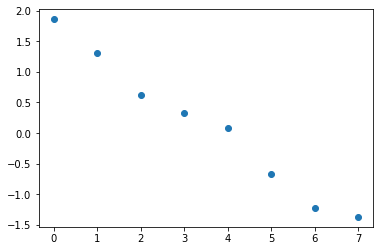

In [4]:
fig, ax = plt.subplots()
_ = ax.scatter(x, y)

Initialize the slope parameter $m$ with a "random" value of 0.9...

In [5]:
m = torch.tensor([0.9]).requires_grad_()
m

tensor([0.9000], requires_grad=True)

...and do the same for the $y$-intercept parameter $b$: 

In [6]:
b = torch.tensor([0.1]).requires_grad_()
b

tensor([0.1000], requires_grad=True)

In [7]:
def regression_plot(my_x, my_y, my_m, my_b):
    
    fig, ax = plt.subplots()

    ax.scatter(my_x, my_y)
    x_min, x_max = ax.get_xlim()
    y_min, y_max = my_b, my_b + my_m*(x_max-x_min)

    ax.plot([x_min, x_max], [y_min, y_max])
    _ = ax.set_xlim([x_min, x_max])

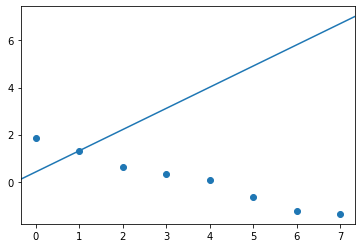

In [8]:
regression_plot(x, y, m, b)

In [9]:
def regression(my_x, my_m, my_b):
    return my_x*my_m + my_b

**Return to slides here if following *Calculus I* class.**

### Machine Learning
In four easy steps :)

**Step 1**: Forward pass

In [10]:
yhat = regression(x, m, b)
yhat

tensor([0.1000, 1.0000, 1.9000, 2.8000, 3.7000, 4.6000, 5.5000, 6.4000],
       grad_fn=<AddBackward0>)

**Step 2**: Compare $\hat{y}$ with true $y$ to calculate cost $C$.

There is a PyTorch `MSELoss` method, but let's define it outselves to see how it works. MSE cost is defined by: $$C = \frac{1}{n} \sum_{i=1}^n (\hat{y_i}-y_i)^2 $$

In [11]:
def mse_cost(my_yhat, my_y): 
    sigma = torch.sum((my_yhat - my_y)**2)
    return sigma/len(my_y)

In [12]:
C = mse_cost(yhat, y)
C

tensor(19.6755, grad_fn=<DivBackward0>)

**Step 3**: Use autodiff to calculate gradients of $C$ w.r.t. parameters

In [13]:
C.backward()

In [14]:
m.grad

tensor([36.3050])

In [15]:
b.grad

tensor([6.2650])

**Step 4**: Gradient descent

In [16]:
optimizer = torch.optim.SGD([m, b], lr=0.05)

In [17]:
optimizer.step()

Confirm parameters have been adjusted sensibly: 

In [18]:
m

tensor([-0.9152], requires_grad=True)

In [19]:
b

tensor([-0.2132], requires_grad=True)

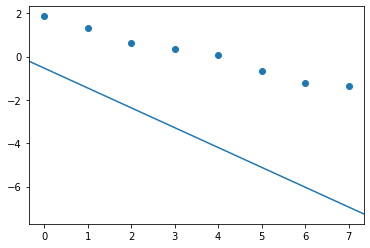

In [20]:
regression_plot(x, y, m, b)

We can repeat steps 1 and 2 to confirm cost has decreased: 

In [21]:
C = mse_cost(regression(x, m, b), y)
C

tensor(13.5536, grad_fn=<DivBackward0>)

Put the 4 steps in a loop to iteratively minimize cost toward zero: 

In [22]:
epochs = 100
for epoch in range(epochs):
    
    optimizer.zero_grad() # Reset gradients to zero; else they accumulate
    
    yhat = regression(x, m, b) # Step 1
    C = mse_cost(yhat, y) # Step 2
    
    C.backward() # Step 3
    optimizer.step() # Step 4
    
    print('Epoch {}, cost {}, m grad {}, b grad {}'.format(epoch, '%.3g' % C.item(), '%.3g' % m.grad.item(), '%.3g' % b.grad.item()))

Epoch 0, cost 13.6, m grad -29.4, b grad -7.07
Epoch 1, cost 9.41, m grad 24.5, b grad 3.94
Epoch 2, cost 6.6, m grad -19.8, b grad -5.05
Epoch 3, cost 4.69, m grad 16.6, b grad 2.38
Epoch 4, cost 3.39, m grad -13.3, b grad -3.67
Epoch 5, cost 2.5, m grad 11.2, b grad 1.35
Epoch 6, cost 1.89, m grad -8.91, b grad -2.72
Epoch 7, cost 1.47, m grad 7.63, b grad 0.668
Epoch 8, cost 1.17, m grad -5.96, b grad -2.07
Epoch 9, cost 0.961, m grad 5.19, b grad 0.222
Epoch 10, cost 0.81, m grad -3.97, b grad -1.62
Epoch 11, cost 0.7, m grad 3.55, b grad -0.0656
Epoch 12, cost 0.617, m grad -2.64, b grad -1.3
Epoch 13, cost 0.553, m grad 2.43, b grad -0.247
Epoch 14, cost 0.502, m grad -1.74, b grad -1.07
Epoch 15, cost 0.461, m grad 1.68, b grad -0.358
Epoch 16, cost 0.427, m grad -1.13, b grad -0.91
Epoch 17, cost 0.398, m grad 1.17, b grad -0.422
Epoch 18, cost 0.372, m grad -0.729, b grad -0.789
Epoch 19, cost 0.349, m grad 0.823, b grad -0.455
Epoch 20, cost 0.329, m grad -0.458, b grad -0.69

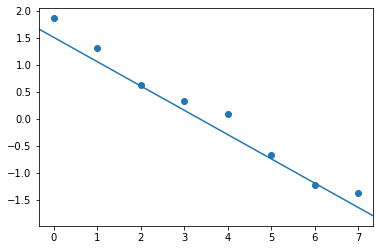

In [23]:
regression_plot(x, y, m, b)